## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from Levenshtein import *
from tensorflow.keras.callbacks import EarlyStopping
from seq_diff import diff_html

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [4]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [5]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [6]:
reverse_char_index = dict((i, char) for char, i in token_index.items())
decode_seq = lambda seq: [ ''.join([ reverse_char_index[i] for i in s ]) for s in np.argmax(seq, axis = 2)]

In [17]:
X_data = encoder_input_data#[:1000]
Y_data = decoder_input_data#[:1000]
print("X_data", X_data.shape)
print("Y_data", Y_data.shape)

X_data (4368, 3822, 4)
Y_data (4368, 3822, 4)


## Inference

In [39]:
model = keras.models.load_model("data/ncbi_02/model_gru_bi_256_8")
model

In [40]:
Y_pred_prev = None

In [41]:
i = 5
x1 = decode_seq(X_data[i:i+1,:,:])[0]
y1 = decode_seq(Y_data[i:i+1,:,:])[0]

_ = diff_html(x1, y1, display_a=True, display_b=True)

In [42]:
yp1 = decode_seq(model.predict(X_data[i:i+1,:,:]))[0]

_ = diff_html(y1, yp1, display_a=True, display_b=True)

2022-03-29 17:43:52.437066: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 3600 num_cores: 6 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 9437184 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [43]:
Y_pred = model.predict(X_data)
Y_pred.shape

(4368, 3822, 4)

## Metrics

In [44]:
keras.losses.CategoricalCrossentropy()(X_data, Y_data).numpy()

0.0074873627

In [45]:
keras.losses.CategoricalCrossentropy()(X_data, Y_pred).numpy()

0.0011939405

In [46]:
keras.losses.CategoricalCrossentropy()(Y_data, Y_pred).numpy()

0.0076178894

In [47]:
if Y_pred_prev is not None:
    print(keras.losses.CategoricalCrossentropy()(Y_pred_prev, Y_pred).numpy())
Y_pred_prev = Y_pred.copy()

In [48]:
cce = []
for i in range(len(decoder_target_data)):
    _ = keras.losses.CategoricalCrossentropy()(Y_data[i:i + 1], Y_pred[i:i + 1]).numpy()
    cce.append(_)
cce = np.array(cce)

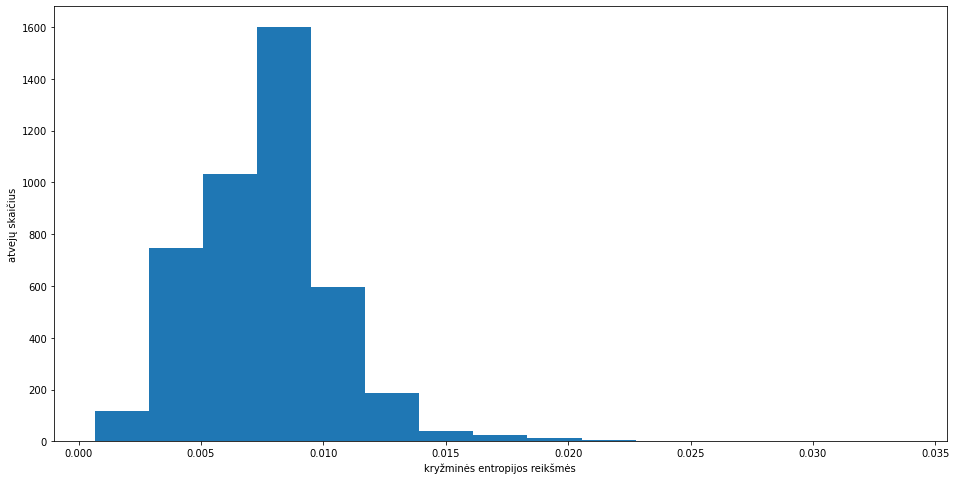

In [49]:
plt.hist(cce, bins = 15)
plt.xlabel('kryžminės entropijos reikšmės')
plt.ylabel('atvejų skaičius')
plt.show()

In [50]:
X_secs = decode_seq(X_data)

In [51]:
Y_secs = decode_seq(Y_data)
Y_pred_secs = decode_seq(Y_pred)

In [52]:
lev_distances = [ distance(x,y) for x,y in zip(Y_secs, Y_pred_secs) ]
lev_ratio = [ ratio(x,y) for x,y in zip(Y_secs, Y_pred_secs) ]
ham_distances = [ hamming(x,y) for x,y in zip(Y_secs, Y_pred_secs) ]

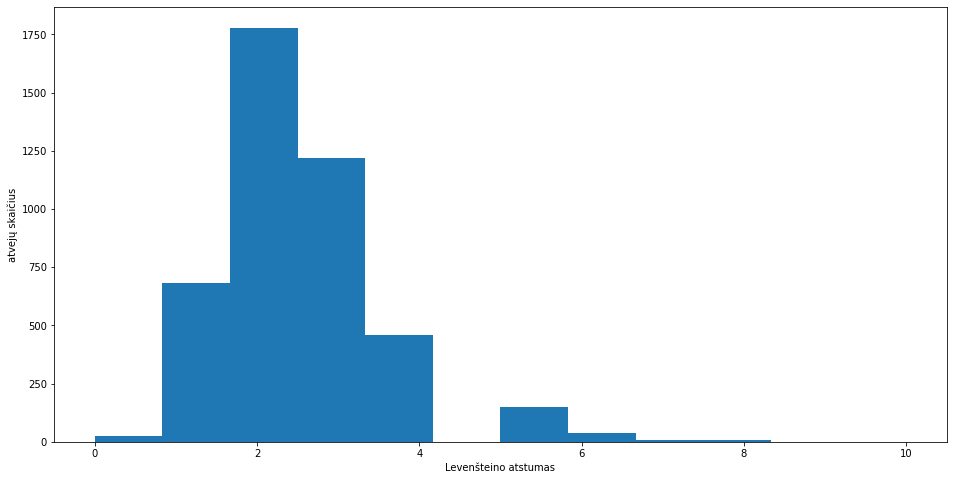

In [61]:
plt.hist(lev_distances, bins = 12)
plt.xlabel('Levenšteino atstumas')
plt.ylabel('atvejų skaičius')
plt.show()

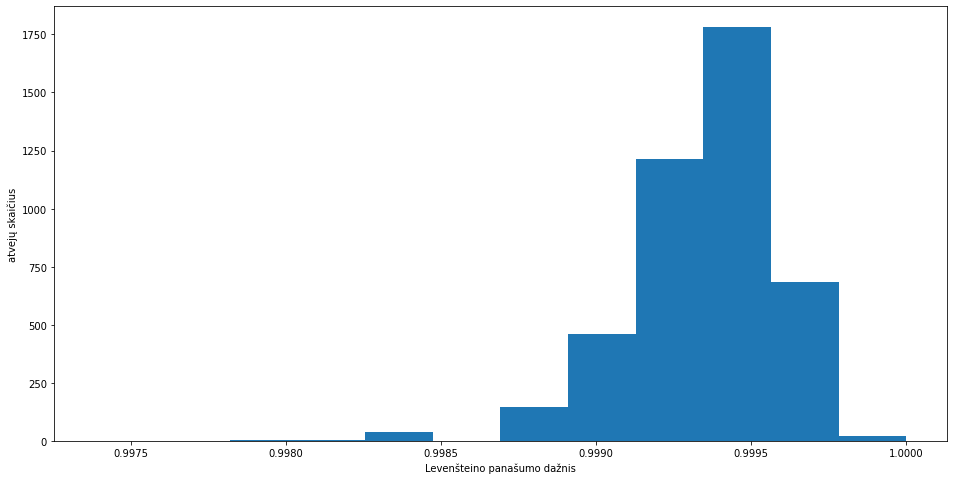

In [63]:
plt.hist(lev_ratio, bins = 12)
plt.xlabel('Levenšteino panašumo dažnis')
plt.ylabel('atvejų skaičius')
plt.show()

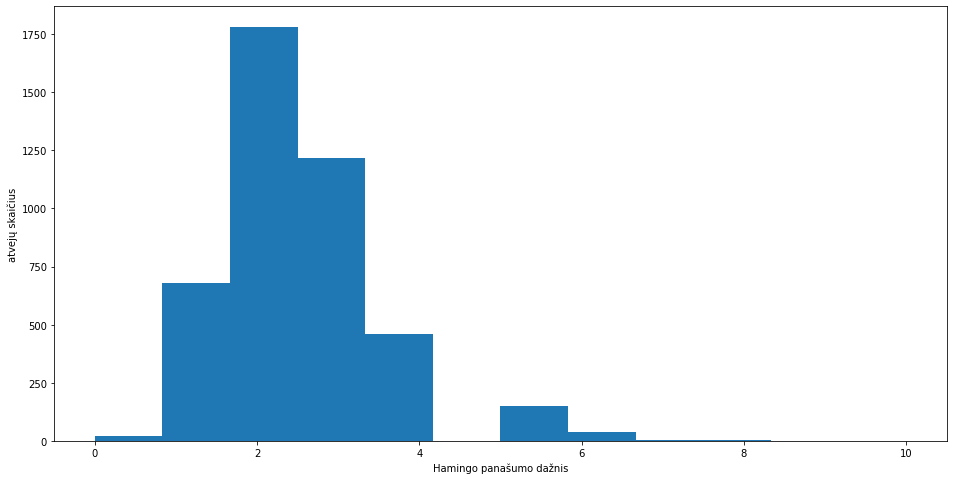

In [64]:
plt.hist(ham_distances, bins = 12)
plt.xlabel('Hamingo panašumo dažnis')
plt.ylabel('atvejų skaičius')
plt.show()

In [65]:
mut01 = np.sum(
    (np.subtract(
        np.argmax(X_data, axis = 2), 
        np.argmax(Y_data, axis = 2)
    ) != 0.0).astype(int), axis = 0)

In [66]:
mut02 = np.sum(
    (np.subtract(
        np.argmax(X_data, axis = 2), 
        np.argmax(Y_pred, axis = 2)
    ) != 0.0).astype(int), axis = 0)

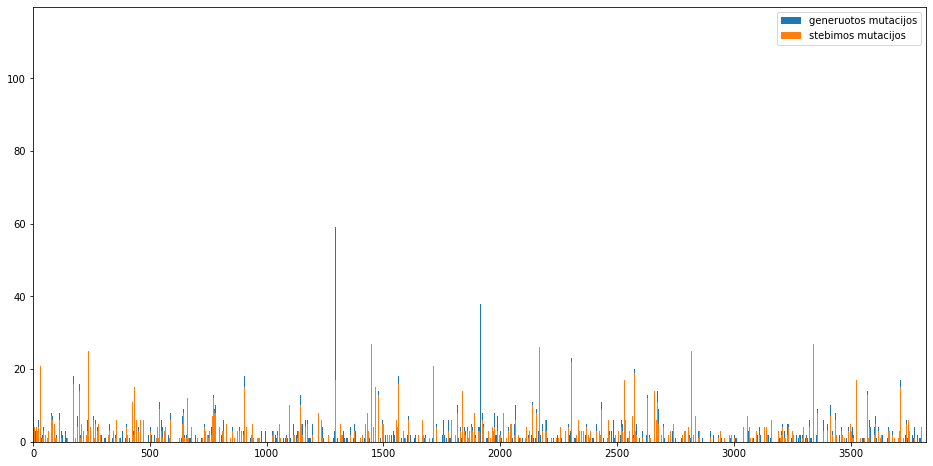

In [67]:
x_range = list(range(len(mut01)))
plt.bar(x_range, mut02, bottom = mut01, label = 'generuotos mutacijos')
plt.bar(x_range, mut01, label = 'stebimos mutacijos')
#plt.ylim(0, 200.0)
plt.xlim(0, len(mut01))
plt.legend()
plt.show()

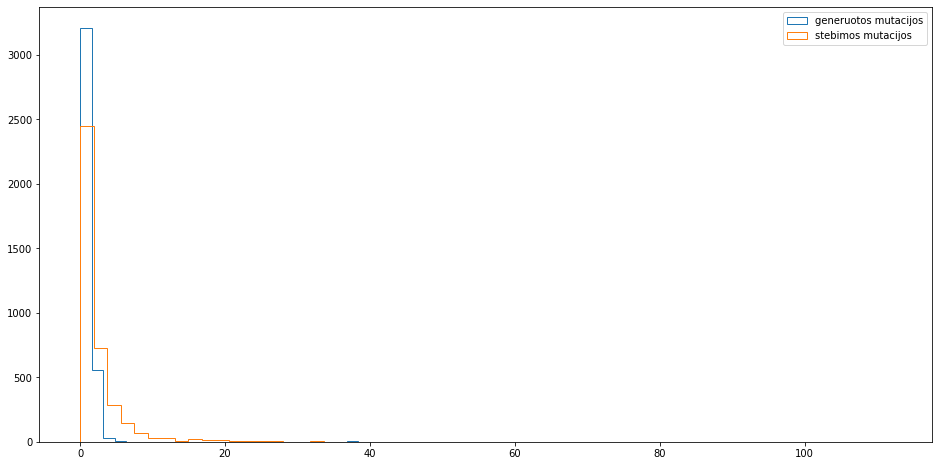

In [68]:
plt.hist(mut02, bins = 60, label = 'generuotos mutacijos', fill = False, histtype='step')
plt.hist(mut01, bins = 60, label = 'stebimos mutacijos', fill = False, histtype='step')
plt.legend()
plt.show()